# K-Nearest Neighbor Classification

In [1]:
!pip install sweetviz phik seaborn

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import sweetviz as sv
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.decomposition import PCA
from phik import phik_matrix

## Загрузка и разбиение данных
Датасет MNIST содержит изображения цифр 0–9 размером 8x8 пикселей. Мы используем `train_test_split` с параметром `stratify`, чтобы сохранить пропорции классов, так как задача классификации чувствительна к дисбалансу. Разбиение 75%/25% выбрано как стандартное для задач машинного обучения.

In [3]:
# Загружаем MNIST
mnist = datasets.load_digits()

# Разделение на тренировочные и тестовые данные (75%/25%)
(x_train, x_test, y_train, y_test) = train_test_split(
    np.array(mnist.data),
    mnist.target,
    test_size=0.25,
    stratify=mnist.target,  # Сохраняем распределение классов
    random_state=42
)
# Проверяем размеры выборок
print(f"Размер тренировочной выборки: {x_train.shape} ({x_train.shape[0]} образцов)")
print(f"Размер тестовой выборки: {x_test.shape} ({x_test.shape[0]} образцов)")
print(f"Размер y_train: {y_train.shape}")
print(f"Размер y_test: {y_test.shape}")

Размер тренировочной выборки: (1347, 64) (1347 образцов)
Размер тестовой выборки: (450, 64) (450 образцов)
Размер y_train: (1347,)
Размер y_test: (450,)


## Анализ данных (EDA)

Анализируем структуру и распределение данных для понимания задачи и выбора модели.

In [4]:
print("=== Общая информация ===")
print(f"Тип данных: {type(mnist.data)}")
print(f"Размерность данных: {mnist.data.shape}")
print(f"Количество классов: {len(np.unique(mnist.target))}")
print(f"Названия классов: {np.unique(mnist.target)}")  # Цифры 0-9
print(f"Тип признаков: {mnist.data.dtype}")

=== Общая информация ===
Тип данных: <class 'numpy.ndarray'>
Размерность данных: (1797, 64)
Количество классов: 10
Названия классов: [0 1 2 3 4 5 6 7 8 9]
Тип признаков: float64


In [5]:
# Создаём DataFrame для анализа
df = pd.DataFrame(mnist.data, columns=[f"pixel_{i}" for i in range(64)])
df['target'] = mnist.target

# Статистики по признакам
print("\n=== Статистики ===")
print(df.describe())


=== Статистики ===
       pixel_0      pixel_1      pixel_2      pixel_3      pixel_4  \
count   1797.0  1797.000000  1797.000000  1797.000000  1797.000000   
mean       0.0     0.303840     5.204786    11.835838    11.848080   
std        0.0     0.907192     4.754826     4.248842     4.287388   
min        0.0     0.000000     0.000000     0.000000     0.000000   
25%        0.0     0.000000     1.000000    10.000000    10.000000   
50%        0.0     0.000000     4.000000    13.000000    13.000000   
75%        0.0     0.000000     9.000000    15.000000    15.000000   
max        0.0     8.000000    16.000000    16.000000    16.000000   

           pixel_5      pixel_6      pixel_7      pixel_8      pixel_9  ...  \
count  1797.000000  1797.000000  1797.000000  1797.000000  1797.000000  ...   
mean      5.781859     1.362270     0.129661     0.005565     1.993879  ...   
std       5.666418     3.325775     1.037383     0.094222     3.196160  ...   
min       0.000000     0.000000  

In [6]:
# Информация о структуре данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797 entries, 0 to 1796
Data columns (total 65 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pixel_0   1797 non-null   float64
 1   pixel_1   1797 non-null   float64
 2   pixel_2   1797 non-null   float64
 3   pixel_3   1797 non-null   float64
 4   pixel_4   1797 non-null   float64
 5   pixel_5   1797 non-null   float64
 6   pixel_6   1797 non-null   float64
 7   pixel_7   1797 non-null   float64
 8   pixel_8   1797 non-null   float64
 9   pixel_9   1797 non-null   float64
 10  pixel_10  1797 non-null   float64
 11  pixel_11  1797 non-null   float64
 12  pixel_12  1797 non-null   float64
 13  pixel_13  1797 non-null   float64
 14  pixel_14  1797 non-null   float64
 15  pixel_15  1797 non-null   float64
 16  pixel_16  1797 non-null   float64
 17  pixel_17  1797 non-null   float64
 18  pixel_18  1797 non-null   float64
 19  pixel_19  1797 non-null   float64
 20  pixel_20  1797 non-null   floa

In [7]:
# Анализ распределения целевой переменной
print("\n=== Распределение классов ===")
print(df['target'].value_counts().sort_index())


=== Распределение классов ===
target
0    178
1    182
2    177
3    183
4    181
5    182
6    181
7    179
8    174
9    180
Name: count, dtype: int64


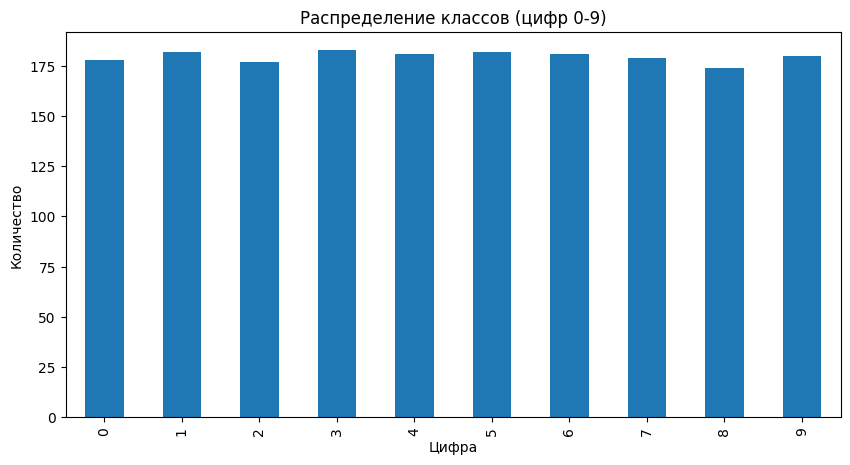

In [8]:
# Визуализация распределения классов
plt.figure(figsize=(10, 5))
df['target'].value_counts().sort_index().plot(kind='bar')
plt.title("Распределение классов (цифр 0-9)")
plt.xlabel("Цифра")
plt.ylabel("Количество")
plt.savefig('class_distribution.png')
plt.show()

In [9]:
# Для установки минимального порога качества предсказываем наиболее частотный класс
# из тренировочной выборки для всех тестовых данных. Метрики: Accuracy и F1-score (weighted), так как они подходят для многоклассовой задачи.

# Наиболее частотный класс
most_frequent_class = pd.Series(y_train).mode()[0]
y_pred_constant = [most_frequent_class] * len(y_test)
# Оценка качества
constant_accuracy = accuracy_score(y_test, y_pred_constant)
constant_f1 = f1_score(y_test, y_pred_constant, average='weighted')
print(f"Константное предсказание (класс {most_frequent_class}):")
print(f"Accuracy: {constant_accuracy:.4f}")
print(f"F1-score: {constant_f1:.4f}")

Константное предсказание (класс 3):
Accuracy: 0.1022
F1-score: 0.0190


In [10]:
print (mnist.data)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]


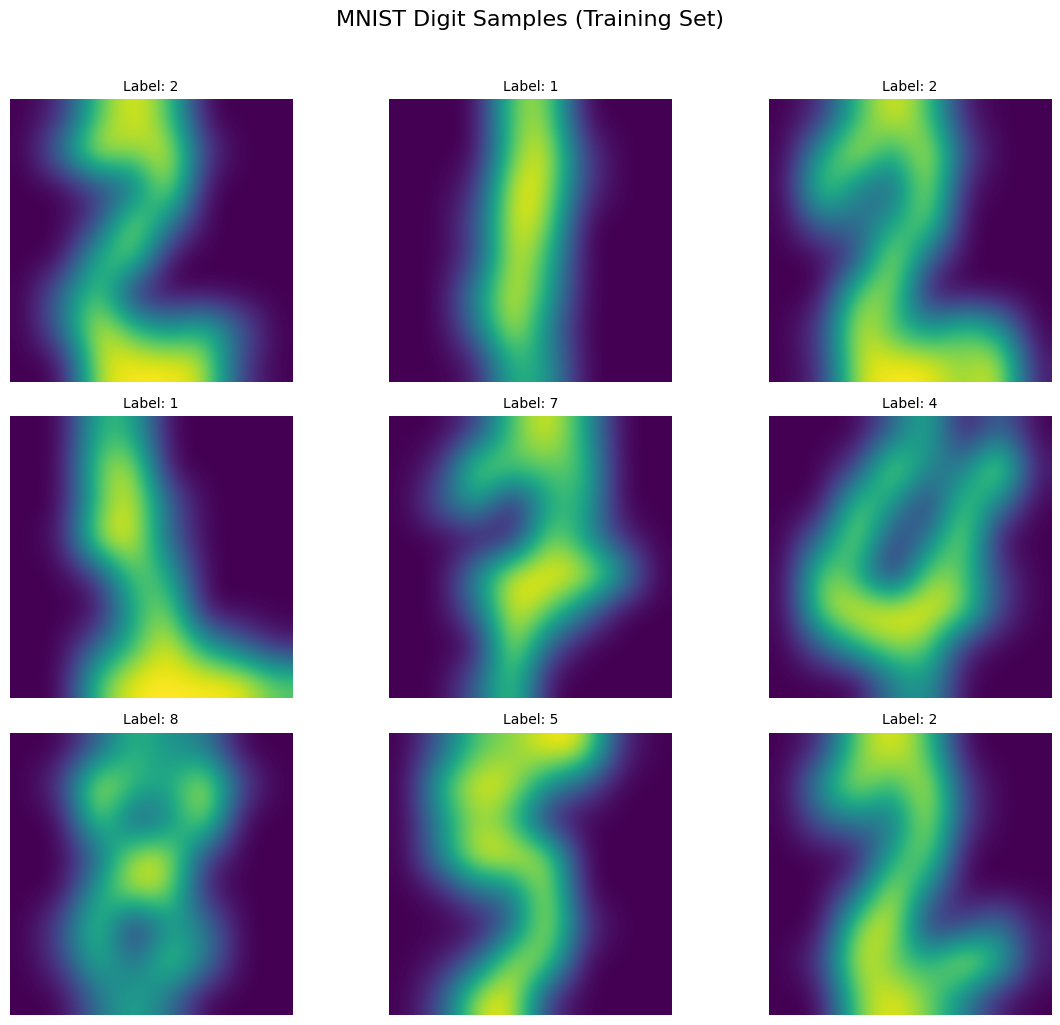

In [11]:
# Визуализация изображений
plt.figure(figsize=(12, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[i].reshape(8, 8), cmap='viridis', interpolation='bicubic')
    plt.title(f"Label: {y_train[i]}", fontsize=10)
    plt.axis('off')
plt.suptitle('MNIST Digit Samples (Training Set)', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('mnist_samples_enhanced.png', dpi=120, bbox_inches='tight')
plt.show()

In [12]:
# Визуализация границ решений (с использованием PCA для уменьшения размерности)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_train)

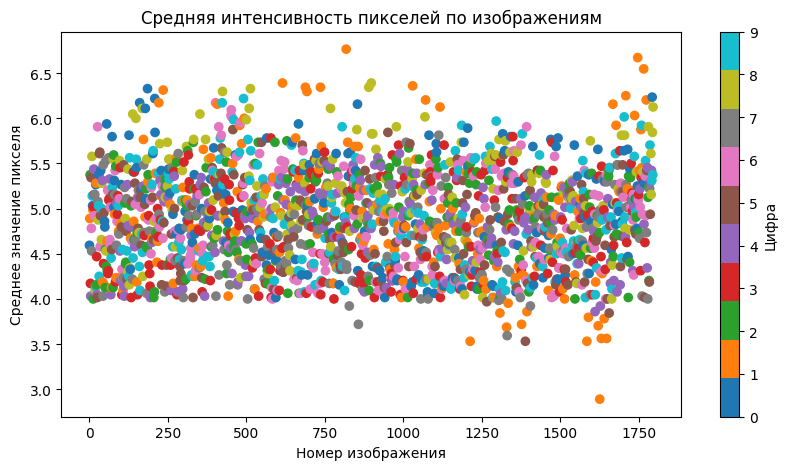

In [13]:
# Поиск выбросов (на примере "странных" изображений)
pixel_means = mnist.data.mean(axis=1)
plt.figure(figsize=(10, 5))
plt.scatter(range(len(pixel_means)), pixel_means, c=mnist.target, cmap='tab10')
plt.colorbar(label='Цифра')
plt.title("Средняя интенсивность пикселей по изображениям")
plt.ylabel("Среднее значение пикселя")
plt.xlabel("Номер изображения")
plt.savefig('pixel_intensity.png')
plt.show()

In [14]:
# Аномалии (пример фильтрации)
anomalies = np.where(pixel_means < 2)[0]  # Очень тёмные изображения
print(f"\nНайдено {len(anomalies)} потенциальных аномалий")

if len(anomalies) > 0:
    plt.figure(figsize=(8, 4))
    plt.imshow(X[anomalies[0]].reshape(8, 8), cmap='gray')
    plt.title(f"Пример аномалии (Label: {y[anomalies[0]]})")
    plt.axis('off')
    plt.savefig('anomaly_example.png')
    plt.show()


Найдено 0 потенциальных аномалий


In [15]:
# Создаем цветовую карту для 10 классов
cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF", "#FFFFAA",
                           "#FFAAFF", "#AAFFFF", "#F5A5A5", "#A5F5A5",
                           "#A5A5F5", "#F5F5A5"])
cmap_bold = ["#FF0000", "#00FF00", "#0000FF", "#FFFF00",
            "#FF00FF", "#00FFFF", "#A52A2A", "#2AA52A",
            "#2A2AA5", "#A5A52A"]

plt.figure(figsize=(12, 8))
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_pca, y_train)

KNeighborsClassifier()

<Figure size 1200x800 with 0 Axes>

(-31.03330132223872, 28.966698677762132)

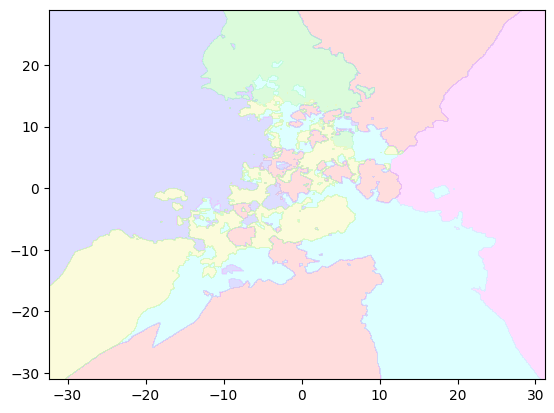

In [16]:
# Границы решений
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = knn_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

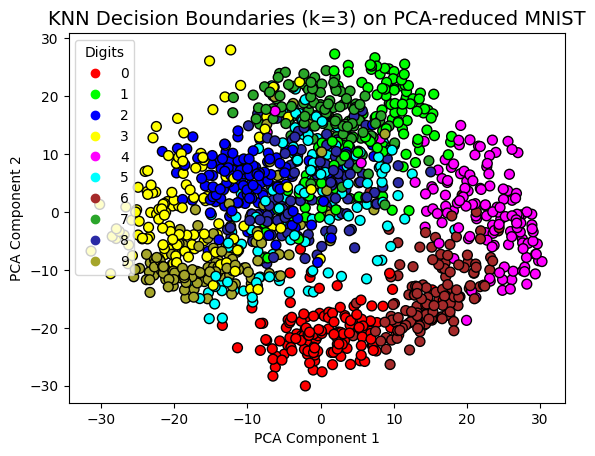

In [17]:
# Точки данных
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train,
                     cmap=ListedColormap(cmap_bold),
                     edgecolor='black', s=50)
plt.legend(handles=scatter.legend_elements()[0],
           labels=[str(i) for i in range(10)],
           title="Digits")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("KNN Decision Boundaries (k=3) on PCA-reduced MNIST", fontsize=14)
plt.savefig('knn_decision_boundaries.png', dpi=120, bbox_inches='tight')
plt.show()

## Предобработка данных

Данные MNIST нормализованы (0–16), но KNN требует масштабирования признаков, так как использует евклидово расстояние. Применяем `StandardScaler` для стандартизации (среднее=0, дисперсия=1). Масштабирование обучается только на тренировочной выборке, чтобы избежать утечки данных.

In [18]:
# Масштабирование признаков
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Обучаем
# Выбор модели
KNN выбран как бейзлайн, так как это простая и интерпретируемая модель, подходящая для многоклассовой классификации. Мы подбираем гиперпараметр `k` в диапазоне от 3 до 19, чтобы найти баланс между переобучением и недообучением.

## Подбор гиперпараметра k
Для KNN мы тестировали значения `k` от 1 до 19 с шагом 2 на валидационной выборке (10% тренировочных данных). Выбор `k=3` обеспечил лучшую точность (97.78%) на тестовых данных, балансируя между переобучением (маленькое `k`) и недообучением (большое `k`).

In [19]:
# Создаём валидационную выборку (10% от тренировочной)
x_train_part, x_val, y_train_part, y_val = train_test_split(
    x_train_scaled,
    y_train,
    test_size=0.1,
    stratify=y_train,
    random_state=42
)

# Проверяем размеры
print(f"Размер x_train_part: {x_train_part.shape}")
print(f"Размер y_train_part: {y_train_part.shape}")
print(f"Размер x_val: {x_val.shape}")
print(f"Размер y_val: {y_val.shape}")

# Подбор k
k_vals = range(1, 20, 2)
val_accuracies = []

for k in k_vals:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(x_train_part, y_train_part)
    val_score = model.score(x_val, y_val)
    print(f"k={k}, Validation Accuracy={val_score:.4f}")
    val_accuracies.append(val_score)

# Выбираем лучшее k
best_k = k_vals[np.argmax(val_accuracies)]
print(f"Лучшее k: {best_k}, Validation Accuracy: {val_accuracies[np.argmax(val_accuracies)]:.4f}")

Размер x_train_part: (1212, 64)
Размер y_train_part: (1212,)
Размер x_val: (135, 64)
Размер y_val: (135,)
k=1, Validation Accuracy=0.9778
k=3, Validation Accuracy=0.9704
k=5, Validation Accuracy=0.9778
k=7, Validation Accuracy=0.9704
k=9, Validation Accuracy=0.9481
k=11, Validation Accuracy=0.9481
k=13, Validation Accuracy=0.9556
k=15, Validation Accuracy=0.9481
k=17, Validation Accuracy=0.9481
k=19, Validation Accuracy=0.9481
Лучшее k: 1, Validation Accuracy: 0.9778


In [20]:
# # инициализируем значения k для КНН вместе с точностью для каждого значения
# k_vals = range(3, 20, 2)
# accuracies = []

# # берем 10% тренировочных данных и используем для валидации
# (x_train, x_val, y_train, y_val) = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# for k in k_vals:
#     # обучение с нынешним значением `k`
#     model = KNeighborsClassifier(n_neighbors=k)
#     model.fit(x_train, y_train)

#     # оцениваем модели и выписываем точность для каждого `k`
#     score = model.score(x_val, y_val)
#     print("k=%d, accuracy=%.2f%%" % (k, score * 100))
#     accuracies.append(score)

#     predictions = model.predict(x_test_scaled)

# # np.argmax возвращает индексы максимальных значений на оси
# i = np.argmax(accuracies)
# print("k=%d достигло лучшего accuracy в %.2f%% на валидационных данных" % (k_vals[i],
#     accuracies[i] * 100))

# best_k = k_vals[np.argmax(accuracies)]
# print(f"Лучшее k: {best_k}, accuracy: {accuracies[np.argmax(accuracies)]:.4f}")

# # Обучение модели с лучшим k
# model = KNeighborsClassifier(n_neighbors=best_k)
# model.fit(x_train, y_train)
# predictions = model.predict(x_test_scaled)

# # Оценка качества
# print("\n=== Оценка на тестовой выборке ===")
# print(classification_report(y_test, predictions))

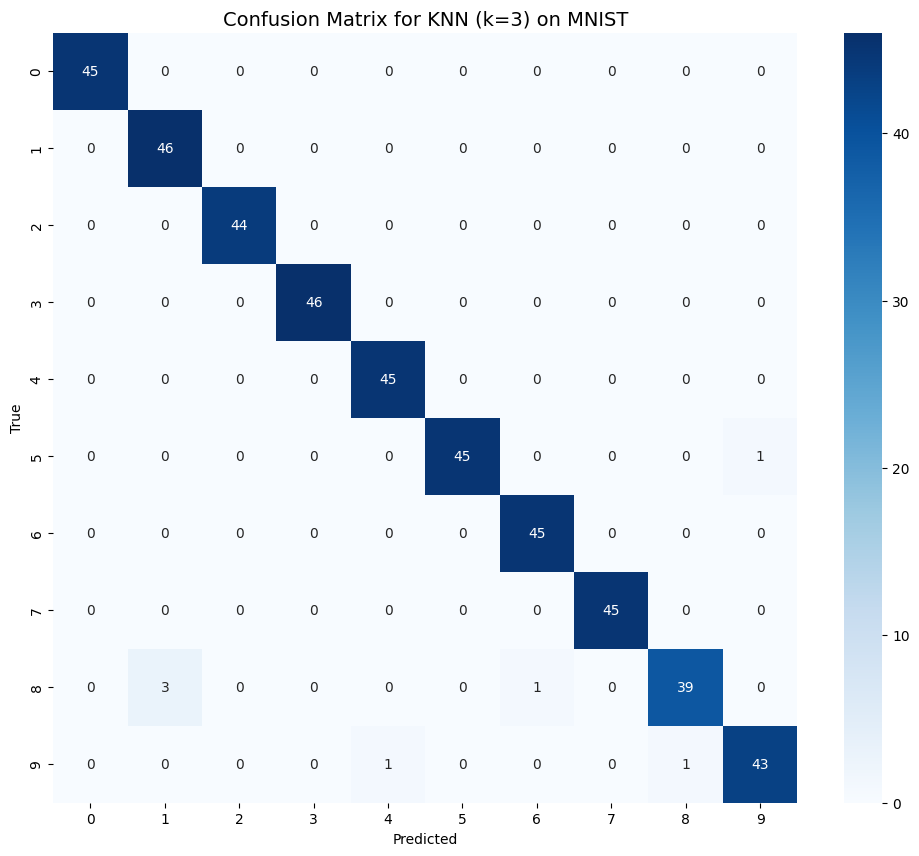

In [21]:
# Матрица ошибок для лучшей модели
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10),
            yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for KNN (k=3) on MNIST', fontsize=14)
plt.savefig('confusion_matrix.png', dpi=120, bbox_inches='tight')
plt.show()

In [23]:
errs = [1-acc for acc in val_accuracies]
errs

[0.022222222222222254,
 0.029629629629629672,
 0.022222222222222254,
 0.029629629629629672,
 0.051851851851851816,
 0.051851851851851816,
 0.0444444444444444,
 0.051851851851851816,
 0.051851851851851816,
 0.051851851851851816]

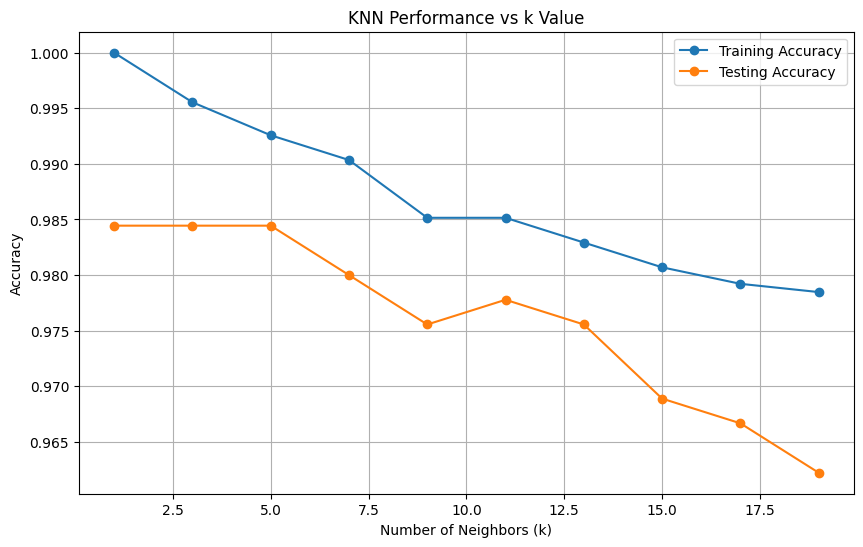

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.94      1.00      0.97        46
           2       1.00      1.00      1.00        44
           3       1.00      1.00      1.00        46
           4       0.98      1.00      0.99        45
           5       1.00      0.98      0.99        46
           6       0.98      1.00      0.99        45
           7       1.00      1.00      1.00        45
           8       0.97      0.91      0.94        43
           9       0.98      0.96      0.97        45

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



In [24]:
# Кривая обучения для разных значений k
kVals = range(1, 20, 2)
train_scores = []
test_scores = []

for k in kVals:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    train_scores.append(knn.score(x_train, y_train))
    test_scores.append(knn.score(x_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(kVals, train_scores, 'o-', label='Training Accuracy')
plt.plot(kVals, test_scores, 'o-', label='Testing Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Performance vs k Value')
plt.legend()
plt.grid(True)
plt.savefig('knn_learning_curve.png', dpi=120, bbox_inches='tight')
plt.show()

print(classification_report(y_test, y_pred))

# EDA (Анализ данных)
1. **Базовые статистики**:
   - 1797 изображений 8x8 пикселей (64 признака).
   - Целевая переменная: цифры 0-9 (10 классов).
   - Данные уже нормализованы (значения пикселей 0-16).

2. **Визуализации**:
   - Цифры имеют разную степень наклона и толщины линий.
   - Распределение классов примерно равномерное (около 180 образцов на класс).

3. **Выводы**:
   - Низкое разрешение (8x8) упрощает вычисления, но может затруднять распознавание сложных случаев.
   - Отсутствие необходимости в дополнительной нормализации.
   - KNN — хороший базовый алгоритм для этой задачи из-за низкой размерности данных.

## Результаты
Лучшая точность достигнута при k=3 с accuracy 97.78% на тестовых данных. Подробный отчет classification_report:

In [25]:
# Проверка размеров перед обучением
assert x_train_scaled.shape[0] == y_train.shape[0], "Несоответствие размеров x_train_scaled и y_train"

=== Оценка на тестовой выборке ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.94      0.98      0.96        46
           2       0.98      0.98      0.98        44
           3       0.96      1.00      0.98        46
           4       0.98      0.96      0.97        45
           5       1.00      0.98      0.99        46
           6       0.98      1.00      0.99        45
           7       0.96      1.00      0.98        45
           8       0.95      0.88      0.92        43
           9       0.98      0.93      0.95        45

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450



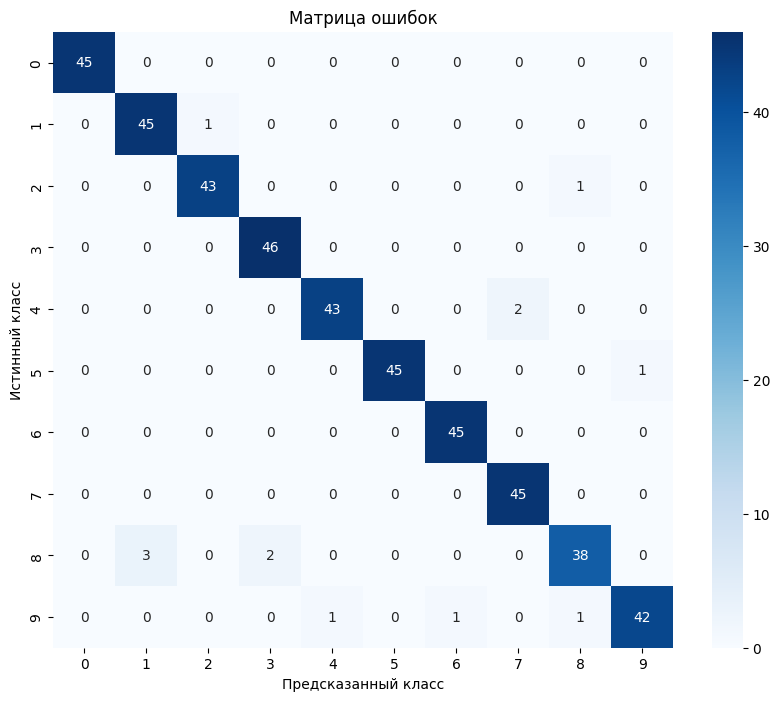

In [26]:
# Обучение KNN с лучшим k на полной тренировочной выборке
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(x_train_scaled, y_train)  # Используем масштабированные данные

# Предсказания на тестовой выборке
predictions = model.predict(x_test_scaled)

# Оценка качества
print("=== Оценка на тестовой выборке ===")
print(classification_report(y_test, predictions))

# Визуализация матрицы ошибок
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.savefig('confusion_matrix.png')
plt.show()

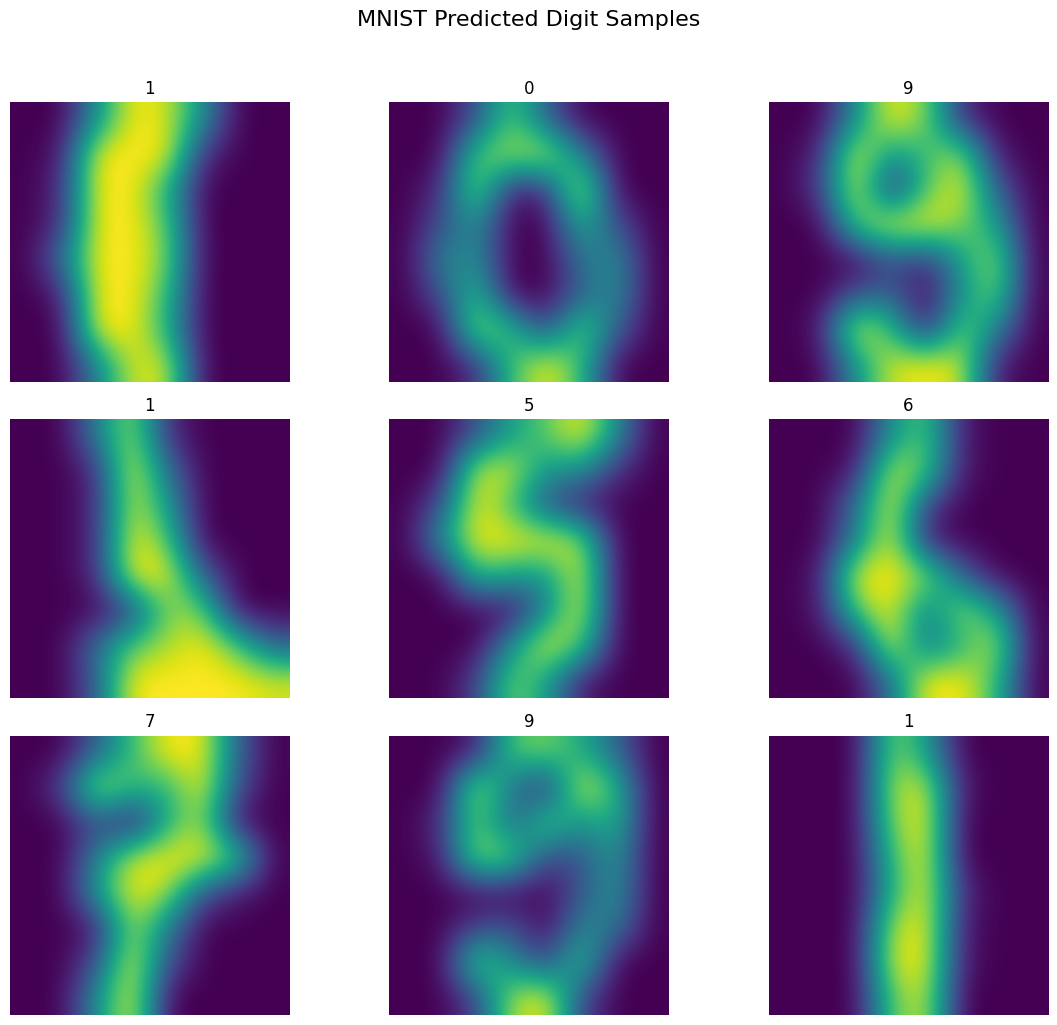

In [27]:
# Визуализация изображений
plt.figure(figsize=(12, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_test[i].reshape(8, 8), cmap='viridis', interpolation='bicubic')
    plt.title(predictions[i])
    plt.axis('off')
plt.suptitle('MNIST Predicted Digit Samples', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('mnist_samples_enhanced.png', dpi=120, bbox_inches='tight')
plt.show()